In [174]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy import signal
import numpy as np
from datetime import *

In [175]:
# Importing all data set (main)
df = []
NUM_DF = 38
for i in range(NUM_DF):
    df.append(pd.read_csv('dataSetMain/current_' + str(i+1) + '.csv'))

In [176]:
# Importing dataSets for understanding
dfClear = pd.read_csv('barFailure/ccs10.csv')
dfClear.drop(dfClear.columns[0], axis=1, inplace=True)
dfBarFailure = pd.read_csv('barFailure/ccs88.csv')
dfBarFailure.drop(dfBarFailure.columns[0], axis=1, inplace=True)

In [177]:
# Global constant variables
fmax = 200
overlap = 0.75

In [195]:
def getData(val : pd.DataFrame, Fs : int) -> pd.DataFrame:
    n = len(val)

    yf = np.abs(fft(val.values)[0:n//2])
    xf = fftfreq(n, 1.0/Fs)[:n//2]  # Берем только положительные частоты

    # Амплитудный спектр (нормированный)
    amplitude_spectrum_db = 20 * np.log10((2.0/n) * yf)

    #energy = 20 * np.log10(yf*yf*xf*xf)

    #values = pd.DataFrame({'freq' : xf, 'ampl' : amplitude_spectrum_db, 'ener' : energy})
    values = pd.DataFrame({'freq' : xf, 'ampl' : amplitude_spectrum_db})

    return values

In [196]:
def getDataClear(val : pd.DataFrame, Fs : int) -> pd.DataFrame:
    x = np.array(val).reshape(-1)
    # x — ваш сигнал (1D numpy array), длительность записи 30–60 c
    # Рекомендуется убрать DC:
    x = signal.detrend(x, type='constant')

    N = len(val)

    f, Pxx = signal.welch(
        x,
        fs=Fs,
        window='hann',
        nperseg=N,
        noverlap=int(N*overlap),
        detrend='constant',
        scaling='density',      # PSD
        average='mean'
    )

    # dB/Hz
    #amplitude_spectrum_db = 10*np.log10(Pxx + np.finfo(float).eps)
    amplitude_spectrum_db = 10*np.log10(Pxx)

    # Рисунок
    mask = (f >= 0) & (f <= fmax)

    values = pd.DataFrame({'freq' : f[mask], 'ampl' : amplitude_spectrum_db[mask]})

    return values

In [197]:
def drawAmpFreq(valX, valY) -> None:
    # Строим график по амплитудам
    plt.figure(figsize=(10,5))
    plt.plot(valX, valY)
    plt.title('Амплитудно-частотная характеристика (АЧХ)')
    plt.ylabel('Амплитуда')
    plt.ylim(-60, 0)  # Ограничиваем диапазон по Y
    plt.xlabel('Частота (Гц)')
    #plt.xaxis.set_major_locator(plt.MultipleLocator(1))  # Новый тик каждые 25 Гц
    plt.grid(True)  # Включаем сетку
    plt.tight_layout();
    plt.show()

In [198]:
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

def getPeaks(val : pd.DataFrame) -> pd.DataFrame:
    # Находим индексы локальных минимумов (сравниваем с 2 соседями)
    '''local_min_indices = argrelextrema(val['ampl'].values, np.greater, order=5)[0]

    print("Индексы локальных минимумов:", local_min_indices)
    print("Значения локальных минимумов:")
    print(val.iloc[local_min_indices])'''

    #local_min_indices = find_peaks(val['ener'], height=np.percentile(val['ener'], 90), prominence=2)[0]  # Отсекает мелкие колебания
    local_min_indices = argrelextrema(val['ampl'].values, np.greater, order=50)[0]
    frequences = val.iloc[local_min_indices]
    frequences = frequences.sort_values(by='ampl', ascending=False)

    return frequences

In [199]:
def saveToFile(peaks : pd.DataFrame, fileName : str) -> None:
    # Writing file with max aplitudes
    maxFrequences = open(fileName, "w")

    # Writing in main array
    for i in peaks.values:
        maxFrequences.write(str(i[0]) + ' ' + str(i[1]) + '\n')

    maxFrequences.close()

In [ ]:
def findImportantFreqiunces(peaks : pd.DataFrame) -> None:
    # Showing most valuable frequnces
    print(peaks[:10])

    # Getting main frequnces
    powerGrid = peaks.iloc[0]
    print('Power grid:', powerGrid['freq'])

    # Getting rotation frequnces
    motorRotation = peaks.iloc[1]
    print('Electric motor rotation frequnces:', motorRotation['freq'])

    numPoles = round(powerGrid['freq'] / motorRotation['freq'])
    print("Num poles:", numPoles)

    slide = (motorRotation['freq']*numPoles - powerGrid['freq'])/powerGrid['freq']
    print("Slide:", slide)

    rotorRotation = peaks.iloc[2]
    print('Rotor after multiplicator:', rotorRotation['freq'])
    

In [221]:
def analyze(data : pd.DataFrame, Fs : float, name : str) -> None:
    # Getting frequnces from data
    column = data.columns[0]
    #value = getData(df[i])
    value = getDataClear(data[column], Fs)

    # Draw getted data
    drawAmpFreq(value['freq'], value['ampl'])
    #drawAmpFreq(value['freq'], value['ener'], axs[2*i+1])

    # Getting peaks
    peaks = getPeaks(value)
    saveToFile(peaks, 'peaks/file'+name+'.txt')
    findImportantFreqiunces(peaks)

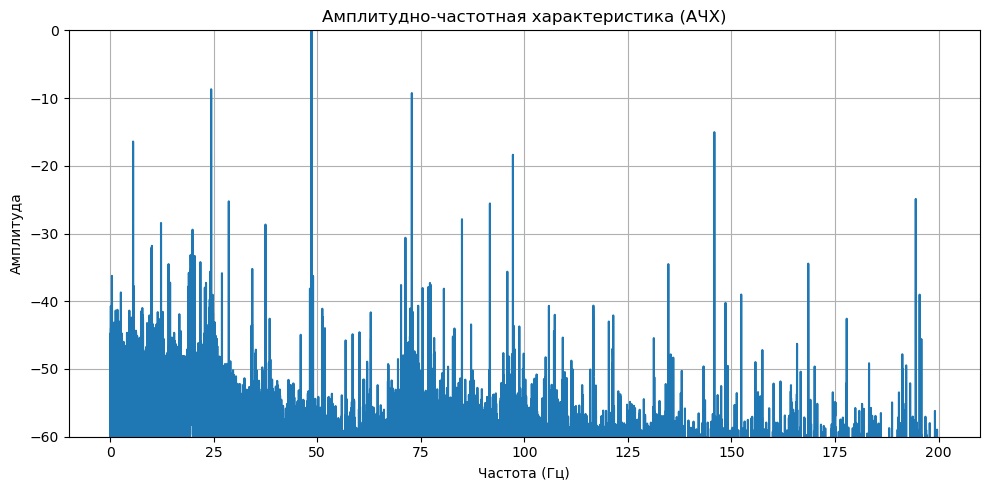

             freq       ampl
5836    48.617776  25.425920
2929    24.400525  -8.700524
8744    72.843358  -9.262215
17509  145.861660 -15.032254
667      5.556555 -16.415898
11673   97.243883 -18.371728
23346  194.487766 -24.894991
3440    28.657497 -25.248734
11006   91.687328 -25.558444
10197   84.947818 -27.889947
Power grid: 48.617776277968346
Electric motor rotation frequnces: 24.400525482893983
Num poles: 2
Slide: 0.003769705277587363
Rotor after multiplicator: 24.400525482893983


In [222]:
analyze(df[37], 25600, '11')

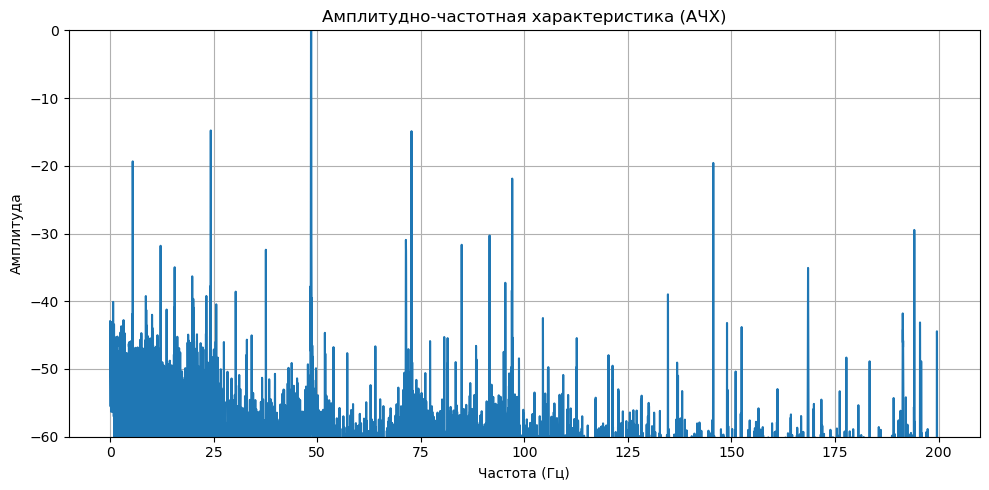

Power grid: 48.5344538077647
Electric motor rotation frequnces: 24.308880228468485
Num poles: 2
Slider: 0.0017164435290079262


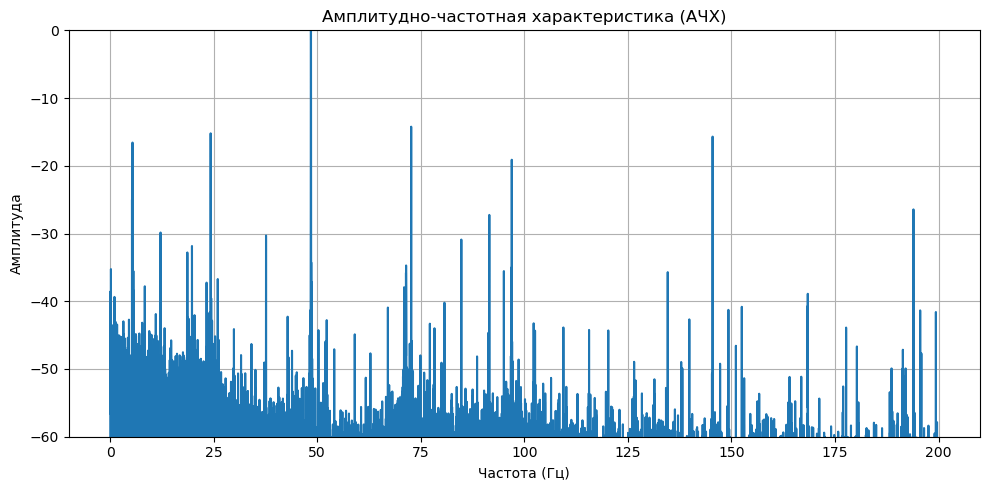

Power grid: 48.48448559591771
Electric motor rotation frequnces: 72.68507505573574
Num poles: 1
Slider: 0.49914089347079027


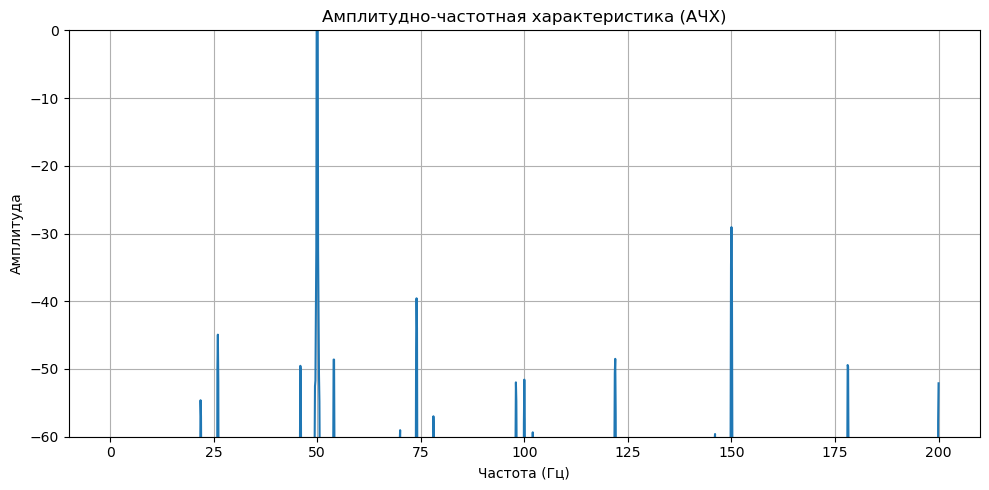

Power grid: 49.99947553757399
Electric motor rotation frequnces: 149.99842661272197
Num poles: 0
Slider: -1.0


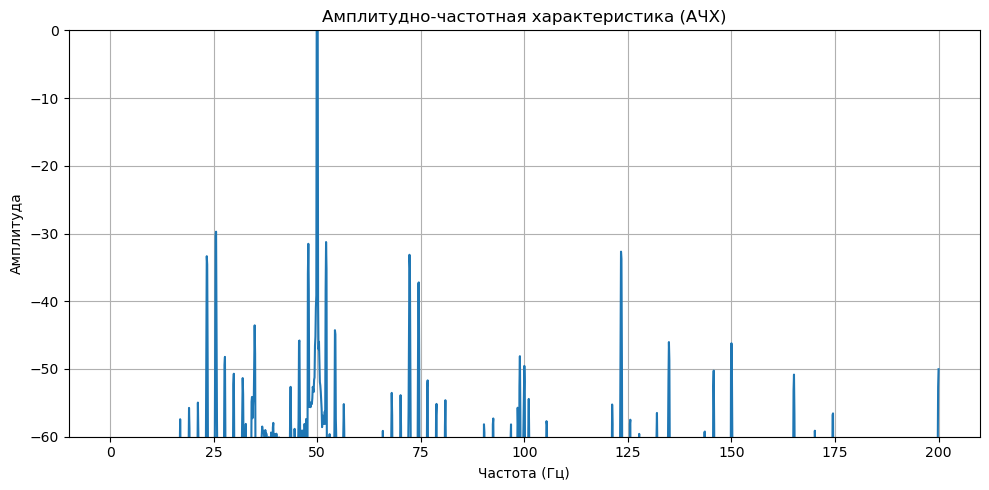

Power grid: 49.99947553757399
Electric motor rotation frequnces: 25.588596688394396
Num poles: 2
Slider: 0.023554603854389625


In [ ]:
graphs = [[df[0], 25600], [df[1], 25600], [dfClear, 1429], [dfBarFailure, 1429]]
index = 0

# Building all graphs
for i in graphs:
    analyze(i[0], i[1], str(index))
    index += 1
